<a href="https://colab.research.google.com/github/Staures92/Projet-de-fin-Data-Afique-Hub/blob/main/Sentimentclient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!fusermount -u /content/drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [68]:
# Importations des bibliothèques necessaires

import pandas as pd # pandas pour charger et explorer les données
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import streamlit as st

# **Importation des données**

In [5]:
#Charger le fichier d'entraînement
df_train = pd.read_parquet('/content/drive/My Drive/train-00000-of-00001.parquet')

# Charger le fichier de test
df_test= pd.read_parquet('/content/drive/My Drive/test-00000-of-00001.parquet')

# df_train = pd.read_parquet('train-00000-of-00001.parquet')
#df = pd.read_parquet('test-00000-of-00001.parquet')

# **Exploration des données**

In [6]:
print(" Train Data:")
print(df_train.head(7))
print(df_train.info())


print("Test Data:")
print(df_test.head(7))
print(df_test.info())

 Train Data:
   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...
5      4  Top notch doctor in a top notch practice. Can'...
6      4  Dr. Eric Goldberg is a fantastic doctor who ha...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   650000 non-null  int64 
 1   text    650000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.9+ MB
None
Test Data:
   label                                               text
0      0  I got 'new' tires from them and within two wee...
1      0  Don't waste your time.  We had two different p...
2  

**Observation** : Les données fournies présentent une structure standard avec deux colonnes, "label" et "text", et une répartition entre un ensemble d'entraînement (650 000 entrées) et un ensemble de test (50 000 entrées).
La colonne "label" est de type "int64", indiquant que les sentiments sont représentés par des nombres entiers.
La colonne "text" est de type "object", ce qui est typique pour stocker des chaînes de caractères dans pandas.

Cependant, les labels (étiquettes) indiquent une classification à 5 (de 0  à 4) classes, et les exemples de texte sont en anglais.

Comme l'ensemble de données d'origine est trop volumineux pour tenir en mémoire de ma machine d'un seul coup, j'ai décidé d'extraire 5 000 entrées en utilisant un échantillonnage stratifié pour garantir que la proportion des différentes catégories dans les données d'origine reste la même dans l'échantillon.

In [7]:
# Identifiez la colonne qui représente la catégorie
category_column = 'label'

# Calculer la fraction à échantillonner (5000 / nombre total de lignes)
fraction = 5000 / len(df_test)

# Effectuer un échantillonnage stratifié
df_sample = df_test.groupby(category_column, group_keys=False).apply(lambda x: x.sample(frac=fraction, random_state=42))

df_sample.shape

(5000, 2)

In [8]:
print("Sample Data:")
print(df_sample.head(7))
print(df_sample.info())

Sample Data:
       label                                               text
31873      0  It was my first day at job. I have to reach at...
23072      0  Never, never again!!  First of all... The only...
7706       0  Used this place before and was satisfied with ...
23399      0  Horrible worst service I've ever had. Slow no ...
22243      0  FIRST -- As I browse the reviews I can't help ...
32246      0  I got acrylics by who I believe to be the owne...
2766       0  R.I.P. Salads N' Such... if you're looking for...
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 31873 to 41181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5000 non-null   int64 
 1   text    5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.2+ KB
None


In [9]:
# Obtenez des catégories uniques de la variable cible 'label' et imprimez-les
categories = df_sample['label'].unique()
print(f"Categories in '{'label'}':")
for category in categories:
    print(category)

Categories in 'label':
0
1
2
3
4


In [10]:
# Vérifier la distribution
original_distribution = df_test['label'].value_counts(normalize=True)
sample_distribution = df_sample['label'].value_counts(normalize=True)

print("Original distribution:")
print(original_distribution)
print("\nSample distribution:")
print(sample_distribution)

Original distribution:
label
0    0.2
2    0.2
1    0.2
3    0.2
4    0.2
Name: proportion, dtype: float64

Sample distribution:
label
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: proportion, dtype: float64


Les résultats de distribution montrent que l'ensemble de données d'origine et l'ensemble de données échantillonné contiennent 5 étiquettes (0 à 4), chacune représentant exactement 20 % des données. Cet équilibre parfait a été maintenu dans le processus d'échantillonnage, démontrant le succès de la technique d'échantillonnage stratifié. L'ensemble de données échantillonné reflète avec précision la distribution des données d'origine, ce qui est idéal pour les tâches d'apprentissage automatique, en particulier les problèmes de classification.

# **Prétraitement des données**

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english')) # utiliser les stop words anglais puisque les exemples de texte sont en anglais
# Download the NLTK vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [12]:
 # Le prétraitement inclut la suppression de la ponctuation, URLs,
 # hashtags, mentions d'utlisateurs et  la conversion en minuscules,
 # la tokenization et la suppression des stop words

 # definir une fonction de prétraitement de texte
def preprocess_text(text):
    # Supprimer les caractères spéciaux
    text = re.sub(r'[^\w\s]', '', text)

    # Supprimer les URLs
    text = re.sub(r'http\S+', '', text)

    # Supprimer les hashtags (mots commençant par #)
    text = re.sub(r'#\w+', '', text)

    # Supprimer les mentions d'utilisateurs (mots commençant par @)
    text = re.sub(r'@\w+', '', text)

    # Convertir en minuscules
    text = text.lower()

    # Tokenization
    # Exemple d'utilisation de la fonction word_tokenize
    # supposons que text = "Check out this awesome #Python tutorial by @katwa! #programming https://www.example.com"
    # tokens va retourner un vecteur de mot individuel ['check', 'out', 'this', 'awesome', 'python', 'tutorial', 'by', 'katwa', 'programming']
    tokens = word_tokenize(text)

    # Supprimer les stop words (mots vides) du texte tokenisé. Exemple des mots vide dans le text ('out', 'this', 'by')
    # qui sont souvent supprimés lors du traitement de texte pour analyser le contenu principal
    tokens = [word for word in tokens if word not in stop_words] # Resultat: ['check', 'awesome', 'python', 'tutorial', 'katwa', 'programming']
    return ' '.join(tokens) # Retourne une chaîne unique en joignant tous les mots traités avec un espace (check awesome python tutorial katwa programming)

In [13]:
# Appliquer la fonction de prétraitement 'preprocess_text' à les colonnes'text' du dataframe 'df_sample' et
# stocker le résultat dans une nouvelle colonne appelée 'processed_text'

df_sample['processed_text'] = df_sample['text'].apply(preprocess_text)


In [14]:
# Le brassage (Shuffling) des données expose le modèle à différents modèles et relations dans les données
# afin d'améliorer ses performances et sa généralisation sur des données invisible
df_sample_shuffled = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Créer une copy du dataframe
df = df_sample_shuffled.copy()

In [15]:
df.head()

,label,text,processed_text
0,1,This buffet was sad times considering the othe...,buffet sad times considering fabulous buffets ...
1,2,This is for the club portion:\n- Dark\n- Expen...,club portionn darkn expensiven weak drinksn sm...
2,2,"Lots to do in the hotel/casino, but it's just ...",lots hotelcasino isolated strip
3,1,I prefer the El Hefe on Mill for having more s...,prefer el hefe mill space nicer staff place pr...
4,0,The food was good a bit overpriced but whateve...,food good bit overpriced whatever problem serv...


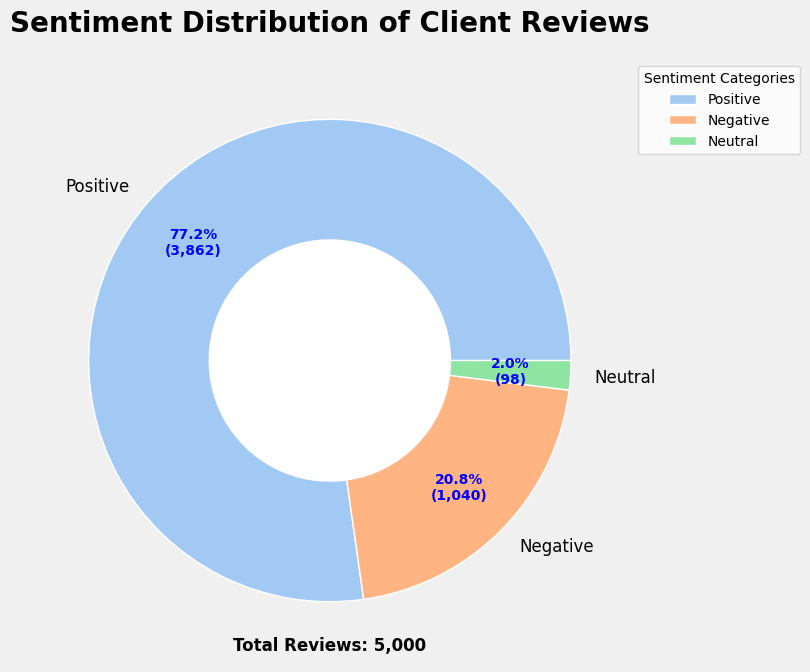

sentiment
Positive    3862
Negative    1040
Neutral       98
Name: count, dtype: int64


In [16]:
# Initialize the NLTK sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Perform sentiment analysis
df['sentiment_scores'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_scores'].apply(get_sentiment)

# Count the sentiments
sentiment_counts = df['sentiment'].value_counts()

# Set up the color palette
colors = sns.color_palette("pastel")[0:3]

# Create the sophisticated pie chart
fig, ax = plt.subplots(figsize=(8, 8), facecolor='#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Create a donut chart
wedges, texts, autotexts = ax.pie(sentiment_counts.values,
                                  labels=sentiment_counts.index,
                                  colors=colors,
                                  autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(sentiment_counts)):,d})',
                                  pctdistance=0.75,
                                  wedgeprops=dict(width=0.5, edgecolor='white'))

# Add a circle at the center to create a donut chart
center_circle = plt.Circle((0,0), 0.50, fc='white')
fig.gca().add_artist(center_circle)

# Customize text properties
plt.setp(autotexts, size=10, weight="bold", color="blue")
plt.setp(texts, size=12)

# Add legend
ax.legend(wedges, sentiment_counts.index,
          title="Sentiment Categories",
          loc="upper left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10)

# Add a title
plt.title('Sentiment Distribution of Client Reviews', fontsize=20, fontweight='bold', pad=20)

# Add a subtitle
plt.text(0, -1.2, f'Total Reviews: {sum(sentiment_counts):,d}',
         horizontalalignment='center', fontsize=12, fontweight='bold')

# Remove axes
ax.axis('off')

plt.tight_layout()

# Show the plot
plt.show()

# Print the counts
print(sentiment_counts)

# **Entraînement des modèles de classification des sentiments**

In [80]:
# Préparation des données pour l'entraînement du modèle

X = df['processed_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

>**1. Un réseau de neurones récurrents (RNN)**

Dans les RNN, les séquences d'entrées doivent être de la même longueur pour être traitées efficacement. En calculant la longueur maximale du texte dans l'ensemble de données, nous obtenons un aperçu de la longueur des séquences d'entrée

In [81]:
# Calculer la longueur maximale du texte
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

max_length = df['text_length'].max()
print("Maximum text length in the dataset:", max_length)

Maximum text length in the dataset: 1002


In [82]:
# Tokeniser les données texte. Cela garantit que le texte est représenté dans un format qui peut être
# compris et traité par des algorithmes d'apprentissage automatique.

# Tokeniser les textes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_rnn = tokenizer.texts_to_sequences(X_train)
X_test_rnn = tokenizer.texts_to_sequences(X_test)

# # Tokeniser les textes pour random forest
X_test = tokenizer.texts_to_sequences(X_test)

In [86]:
# Padding pour avoir des séquences de même longueur

X_train_rnn = pad_sequences(X_train_rnn, maxlen=max_length)
X_test_rnn = pad_sequences(X_test_rnn, maxlen=max_length)

In [88]:
# Entraîner un modèle RNN
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length))
model_rnn.add(LSTM(128))
model_rnn.add(Dense(5, activation='softmax'))
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_rnn.fit(X_train_rnn, y_train, epochs=5, batch_size=64)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.2579 - loss: 1.5861
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.5054 - loss: 1.2100
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.6756 - loss: 0.8234
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.8027 - loss: 0.5451
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.9110 - loss: 0.2863


>**2. Random Forest**

In [100]:
# Entraîner un modèle Random Forest
vectorizer = CountVectorizer()
X_train_rf = vectorizer.fit_transform(X)


# Sauvegarder le vectorizer
joblib.dump(vectorizer, 'vectorizer.joblib')



['vectorizer.joblib']

In [101]:
# Créer un modèle Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train_rf, y)

RandomForestClassifier()

# **Evaluation des modèles de classification des sentiments**

In [84]:
# Convert the padded sequences back to text format
X_test_text = tokenizer.sequences_to_texts(X_test)

# Transform the text data using the CountVectorizer
X_test_rf = vectorizer.transform(X_test_text)

In [90]:
# Évaluer les modèles
score_rnn = model_rnn.evaluate(X_test_rnn, y_test)
# Evaluate the Random Forest model using the transformed test data
score_rf = model_rf.score(X_test_rf, y_test)

score_rnn,score_rf

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 528ms/step - accuracy: 0.4623 - loss: 1.7344


([1.7316534519195557, 0.460999995470047], 1.0)

In [70]:
# Utiliser le modèle ayant la meilleure performance pour prédire les sentiments des avis clients
if score_rnn[1] > score_rf:
    predictions = model_rnn.predict(X_test_rnn)
else:
    predictions = model_rf.predict(X_test_rf)

32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 541ms/step


In [71]:
# Afficher les prédictions, qui sont les scores de probabilité pour chaque classe de sentiments prédits par le modèle
print(predictions)

[[0.16433688 0.03325817 0.17277716 0.8640158  0.9864816 ]
 [0.05649861 0.57272816 0.9460289  0.8716915  0.12533168]
 [0.9911257  0.8923603  0.15186927 0.03932088 0.08592919]
 ...
 [0.39939702 0.4107295  0.5159131  0.6419872  0.49291468]
 [0.08278992 0.910574   0.98028195 0.575888   0.02321457]
 [0.9720167  0.51124626 0.08793963 0.12027492 0.57699305]]


In [72]:

# Obtenir l'indice de la classe prédite pour chaque avis client
predicted_classes = np.argmax(predictions, axis=1)

# Afficher les classes prédites
print(predicted_classes)

[4 2 0 2 4 1 1 2 1 3 4 1 3 4 3 1 0 3 0 4 3 2 4 2 3 1 4 1 0 0 3 4 3 2 1 2 3
 3 3 1 3 1 1 4 2 4 2 1 4 4 3 2 2 2 2 4 3 4 1 3 0 4 0 4 1 1 1 3 2 1 2 2 3 2
 4 0 1 4 0 4 1 4 2 2 4 2 3 3 0 3 1 3 2 4 1 1 0 2 2 4 0 3 3 2 3 1 3 4 3 4 0
 2 4 3 3 0 3 4 1 1 1 3 3 3 1 0 0 4 4 0 2 4 4 1 1 0 2 2 3 1 2 1 1 4 4 3 0 3
 1 3 0 2 0 4 1 2 3 3 3 4 0 4 0 4 4 3 2 3 2 4 3 1 3 2 0 4 4 1 0 3 3 1 0 2 3
 3 4 0 4 3 1 4 3 2 4 0 4 1 4 1 2 4 3 1 4 3 4 3 4 1 0 0 2 2 0 3 3 3 2 3 4 1
 0 4 3 4 3 1 2 3 3 4 1 3 1 1 2 3 2 4 3 3 3 3 3 0 0 1 4 4 1 2 0 4 0 1 3 0 0
 2 2 0 3 2 2 1 3 0 2 3 4 0 4 0 1 2 1 0 4 4 2 4 0 3 2 1 4 3 2 0 0 3 3 0 3 1
 4 4 3 1 2 1 2 4 1 1 1 1 3 2 1 0 1 4 0 2 4 3 4 1 3 0 3 4 4 2 4 0 1 3 0 2 4
 3 1 2 4 1 4 3 3 3 2 3 3 3 2 2 2 3 3 0 2 0 4 0 1 3 3 0 0 3 2 3 2 1 4 3 3 3
 1 3 0 2 3 3 0 2 0 0 0 1 3 2 0 0 1 0 4 1 1 3 0 3 2 3 3 0 3 0 3 4 0 0 0 4 4
 1 1 4 1 4 2 3 2 3 4 2 1 3 4 0 4 3 1 1 2 0 1 1 1 4 3 4 2 0 1 4 2 3 1 4 3 2
 1 0 3 2 0 1 3 1 0 4 4 3 0 2 0 1 4 4 1 4 2 1 2 4 3 4 1 2 2 3 2 3 4 0 2 1 2
 3 2 0 0 1 1 2 3 0 3 1 3 

In [91]:
from sklearn.model_selection import RandomizedSearchCV


# Définir les hyperparamètres à rechercher
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None]
}

In [95]:
# Recherche aléatoire des hyperparamètres avec validation croisée
random_search = RandomizedSearchCV(model_rf, param_distributions=param_grid, n_iter=5, cv=5)
random_search.fit(X_train_rf, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [5, 10, 15, None],
                                        'n_estimators': [50, 100, 150]})

In [96]:
# Obtenir les meilleurs paramètres
best_params = random_search.best_params_

In [98]:
# Entraîner le modèle avec les meilleurs paramètres
final_model_rf = RandomForestClassifier(**best_params)
final_model_rf.fit(X_train_rf, y)

RandomForestClassifier()

In [99]:
# Evaluate the final Random Forest model
final_score_rf = final_model_rf.score(X_test_rf, y_test)
final_score_rf

1.0

In [52]:
# Import the joblib library
import joblib

# Save the Random Forest model
joblib.dump(model_rf, 'client_review_classifier.joblib')

['client_review_classifier.joblib']